In [1]:
import numpy as np
from simpeg.electromagnetics import natural_source as nsem
from simpeg import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from simpeg.utils import plot_1d_layer_model
from discretize import TensorMesh
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

In [2]:
from mtpy import MTCollection
mc = MTCollection()
mc.open_collection("../../data/transfer_functions/yellowstone_mt_collection.h5")

from ipywidgets import widgets, interact
station_names = mc.dataframe.station.values
def foo(name, component):
    tf = mc.get_tf(name)
    tf.plot_mt_response()
Q = interact(
    foo, 
    name=widgets.Select(options=station_names, value='YNP05S'),
    component=widgets.RadioButtons(options=['xy', 'yx', 'det'], value='xy')
)

interactive(children=(Select(description='name', index=144, options=('IDD11', 'IDD12', 'IDE11', 'IDE12', 'IDF1…

24:10:30T22:26:20 | WARNING | line:311 |mtpy.core.mt_collection | get_tf | Found multiple transfer functions with ID YNP05S. Suggest setting survey, otherwise returning the TF from survey YSBB.


Text(0.5, 1.0, 'YNP05S')

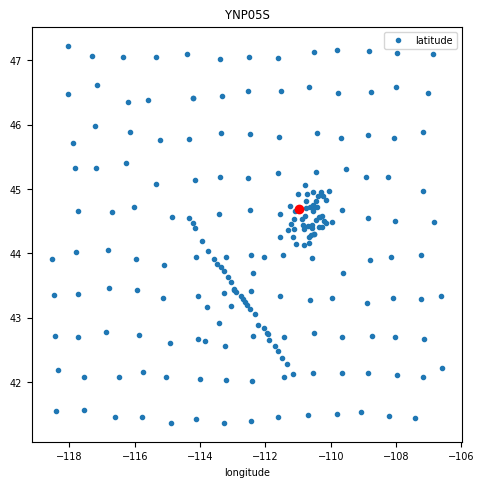

In [3]:
name = Q.widget.kwargs['name']
component = Q.widget.kwargs['component']
tf = mc.get_tf(name)

fig, ax = plt.subplots(1,1, figsize=(5,5))
mc.dataframe.plot(x='longitude', y='latitude', marker='.', linestyle='None', ax=ax)
ax.plot(tf.longitude, tf.latitude, 'ro')
ax.set_title(name)

In [4]:
if component == 'xy':
    print ('>> Use Zxy')
    dobs = np.c_[tf.Z.res_xy, tf.Z.phase_xy].flatten()
    dobs_error = np.c_[tf.Z.res_error_xy, tf.Z.phase_error_xy].flatten()
elif component == 'yx':
    print ('>> Use Zyx')
    dobs = np.c_[tf.Z.res_yx, tf.Z.phase_yx].flatten()
    dobs_error = np.c_[tf.Z.res_error_yx, tf.Z.phase_error_yx].flatten()    
elif component == 'det':
    print ('>> Use determinant')
    dobs = np.c_[tf.Z.res_det, tf.Z.phase_det].flatten()
    dobs_error = np.c_[tf.Z.res_error_det, tf.Z.phase_error_det].flatten()    
    
frequencies = 1./tf.period

>> Use Zxy


In [5]:
tf.Z.z.real[:,0,0]

array([-1.0593e+02, -9.2574e+01, -7.2999e+01, -5.9715e+01, -4.5300e+01,
       -3.6534e+01, -2.7935e+01, -2.3598e+01, -1.8590e+01, -1.7163e+01,
       -1.3645e+01, -1.2296e+01, -9.5656e+00, -7.9090e+00, -5.4159e+00,
       -3.8748e+00, -2.0633e+00, -9.6175e-01, -2.0381e-01,  3.1078e-01,
        2.5246e-01,  8.7086e-02,  5.3124e-01,  7.1696e-01,  5.9307e-01,
        6.3013e-01,  4.9378e-01,  4.3698e-01,  3.2330e-01,  2.7804e-01,
        2.2583e-01,  2.1039e-01,  1.1930e-01,  1.0868e-01,  5.8183e-02,
        6.6387e-02,  2.0888e-02])

In [6]:
tf.frequency

array([2.5600e+02, 1.9200e+02, 1.2800e+02, 9.6000e+01, 6.4000e+01,
       4.8000e+01, 3.2000e+01, 2.4000e+01, 1.6000e+01, 1.2000e+01,
       8.0000e+00, 6.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00,
       1.5000e+00, 1.0000e+00, 7.5000e-01, 5.0000e-01, 3.7500e-01,
       2.5000e-01, 1.8750e-01, 1.2500e-01, 9.3750e-02, 6.2500e-02,
       4.6875e-02, 3.1250e-02, 2.3438e-02, 1.5625e-02, 1.1719e-02,
       7.8125e-03, 5.8594e-03, 3.9062e-03, 2.9297e-03, 1.9531e-03,
       1.4648e-03, 9.7656e-04])

In [7]:
dobs

array([358.90273828,  51.43326537, 340.34661177,  53.9133755 ,
       302.42469781,  57.90557602, 269.34608354,  60.37133516,
       221.96027781,  62.74461371, 189.95761582,  63.72680514,
       152.88693152,  63.97985439, 133.76857224,  63.58541656,
       105.95059052,  62.25563314,  95.92547857,  60.92500333,
        77.011205  ,  57.89460134,  69.94257313,  54.78715573,
        62.9872013 ,  48.970946  ,  62.92421633,  44.61624917,
        68.5985021 ,  39.65404125,  75.7476336 ,  37.27663258,
        88.1884576 ,  35.34609626,  97.08520987,  35.38513329,
       113.08421156,  36.46588642, 117.82627586,  36.89441412,
       138.89824131,  39.15962482, 150.27927762,  40.87831867,
       151.41859042,  47.82852651, 148.12503966,  52.10125548,
       125.19427549,  54.7742191 , 117.35936073,  58.25250697,
        93.89116576,  61.77229208,  81.4369936 ,  61.98162578,
        65.47057318,  61.70010215,  60.06469253,  60.59230301,
        50.15375403,  55.3470202 ,  45.83228582,  53.68

In [8]:
dz = 50
n_layer = 31
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]

In [9]:
def run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=100,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=False,
    p_s=2,
    p_z=2
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, reference_model=mref, mapping=maps.IdentityMap(mesh_inv))
    print (reg.alpha_s, reg.alpha_z)
    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG, tolG=1e-40, eps=1e-30)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)
    precond = directives.UpdatePreconditioner()
    
    if use_irls:
        reg.norms = np.r_[p_s, p_z]
        reg.gradient_type = 'components'
        # Reach target misfit for L2 solution, then use IRLS until model stops changing.
        IRLS = directives.Update_IRLS(max_irls_iterations=100, minGNiter=1, f_min_change=1e-5)
        IRLS.coolEpsFact = 1.5
        precond = directives.UpdatePreconditioner()
        # The directives are defined as a list.
        directives_list = [
            IRLS,
            starting_beta,
            save_dictionary,
            precond
        ]
    else:
        # The directives are defined as a list.
        directives_list = [
            starting_beta,
            beta_schedule,
            target_misfit,
            save_dictionary
        ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict

In [10]:
relative_error_rho = 0.05
floor_phase = 2.
rho_app = dobs.reshape((len(frequencies), 2))[:,0]
phase = dobs.reshape((len(frequencies), 2))[:,1]
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten() 
# standard_deviation += dobs_error
rho_0 = 100
rho_ref = 100.

## Run Smooth L2-norm inversion

In [11]:
recovered_model, output_dict = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    p_s = 2, 
    p_z = 2,
)

1e-10 2500.0

Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.09e+04  6.78e+03  0.00e+00  6.78e+03    3.96e+03      0              
   1  1.04e+04  6.22e+02  9.14e-03  7.17e+02    8.13e+02      0              
   2  5.22e+03  7.55e+01  1.34e-02  1.45e+02    1.04e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 6.7843e+02
1 : |xc-x_last| = 1.5013e+00 <= tolX*(1+|x0|) = 2.6641e+00
0 : |proj(x-g)-x|    = 1.0393e+02 <= to

In [12]:
target_misfit = dobs.size
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [13]:
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [14]:
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=3, description='iteration', max=3, min=1), RadioButtons(description='sca…

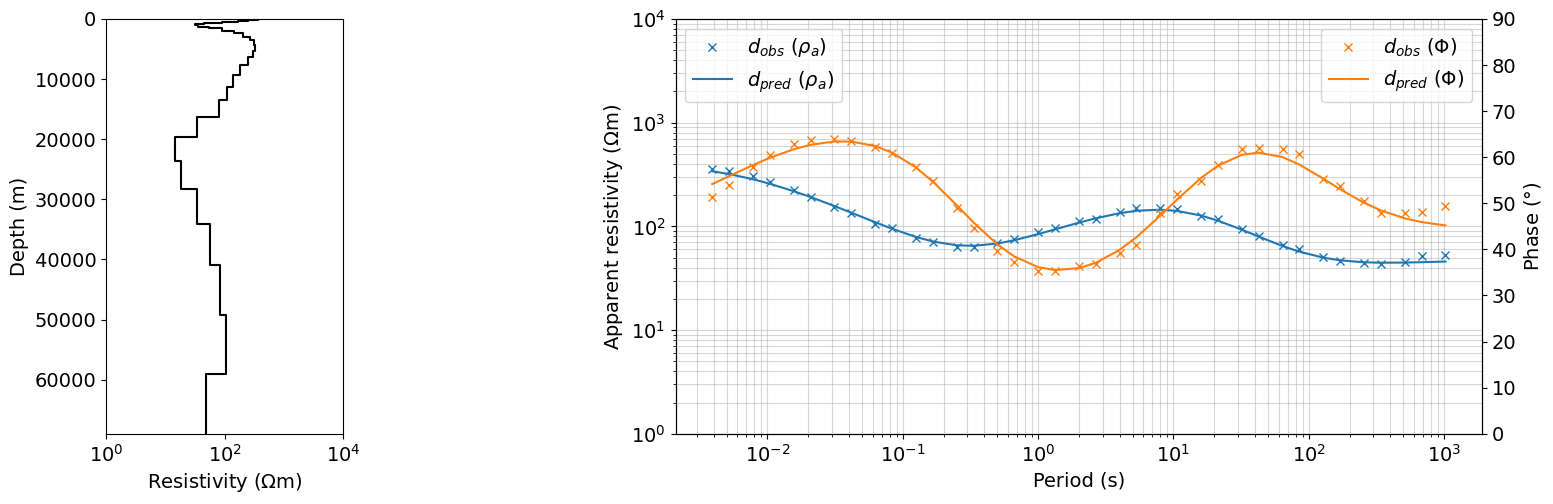

In [15]:
iteration = Q_iter.widget.kwargs['iteration']
dpred = output_dict[iteration]['dpred']
m = output_dict[iteration]['m']
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'linestyle':'-'},
)
# ax0.legend()
ax0.set_xlabel("Resistivity ($\Omega$m)")
# ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label=r'$d_{obs}$ ($\rho_{a}$)')
ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label=r'$d_{pred}$ ($\rho_{a}$)')

ax_1 = ax.twinx()
ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label=r'$d_{obs}$ ($\Phi$)')
ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label=r'$d_{pred}$ ($\Phi$)')
ax.set_xlabel("Period (s)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
# ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=2)
ax_1.legend(loc=1)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
plt.show()

## Run Sparse norm inverion with p_s=2 and p_z=0

In [16]:
recovered_model_ps_2_pz_0, output_dict_ps_2_pz_0 = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=40,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=True,
    p_s=2,
    p_z=0
)

1e-10 2500.0

Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.64e+04  6.78e+03  0.00e+00  6.78e+03    3.96e+03      0              
   1  8.19e+03  5.51e+02  1.16e-02  6.46e+02    8.47e+02      0              
   2  4.09e+03  7.91e+01  1.27e-02  1.31e+02    2.26e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 1.8081260512062256
   3  2.05e+03  3.65e+01  2.16e-03  4.09e+01    5.46e+01      0              
   4  4.32e+03  3.33e+01  7

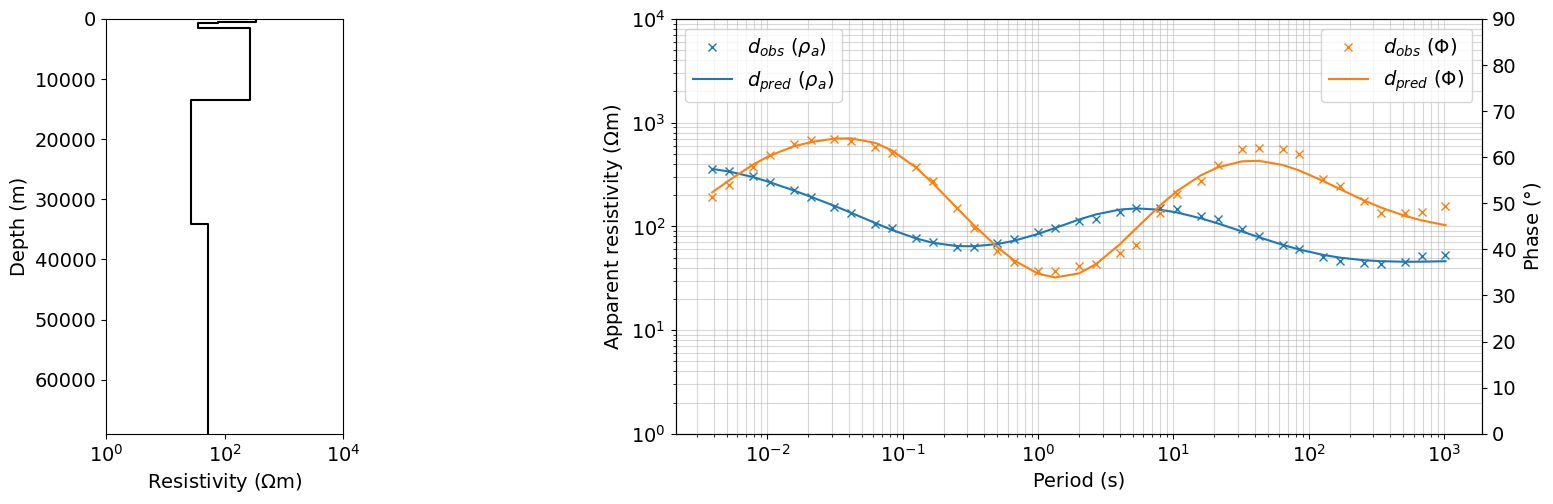

In [17]:
iteration = 40
dpred = output_dict_ps_2_pz_0[iteration]['dpred']
m = output_dict_ps_2_pz_0[iteration]['m']
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'linestyle':'-'},
)
# ax0.legend()
ax0.set_xlabel(r"Resistivity ($\Omega$m)")
# ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label=r'$d_{obs}$ ($\rho_{a}$)')
ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label=r'$d_{pred}$ ($\rho_{a}$)')

ax_1 = ax.twinx()
ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label=r'$d_{obs}$ ($\Phi$)')
ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label=r'$d_{pred}$ ($\Phi$)')
ax.set_xlabel("Period (s)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel(r"Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel(r"Phase ($\degree$)")
# ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=2)
ax_1.legend(loc=1)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
plt.show()

## Run sparse norm inverion with p_s=0 and p_z=0

In [18]:
recovered_model_ps_0_pz_0, output_dict_ps_0_pz_0 = run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=40,
    maxIterCG=30,
    alpha_s=1,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=True,
    p_s=0,
    p_z=0
)

1.0 2500.0

Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.07e-01  6.78e+03  0.00e+00  6.78e+03    3.96e+03      0              
   1  5.35e-02  1.92e+03  9.80e+03  2.45e+03    1.06e+03      0              
   2  2.68e-02  7.71e+02  1.70e+04  1.23e+03    4.59e+02      0              
   3  1.34e-02  2.90e+02  2.56e+04  6.33e+02    2.44e+02      0   Skip BFGS  
   4  6.69e-03  1.17e+02  3.28e+04  3.36e+02    1.10e+02      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start

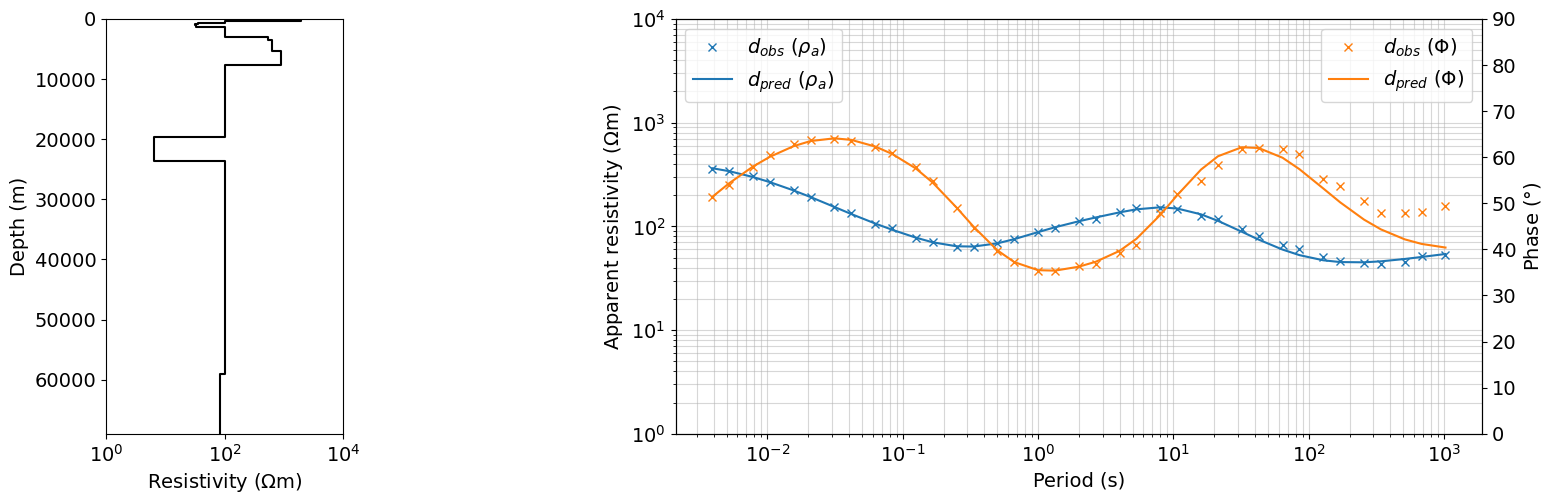

In [19]:
iteration = 40
dpred = output_dict_ps_0_pz_0[iteration]['dpred']
m = output_dict_ps_0_pz_0[iteration]['m']
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'linestyle':'-'},
)
# ax0.legend()
ax0.set_xlabel(r"Resistivity ($\Omega$m)")
# ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label=r'$d_{obs}$ ($\rho_{a}$)')
ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label=r'$d_{pred}$ ($\rho_{a}$)')

ax_1 = ax.twinx()
ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label=r'$d_{obs}$ ($\Phi$)')
ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label=r'$d_{pred}$ ($\Phi$)')
ax.set_xlabel("Period (s)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel(r"Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel(r"Phase ($\degree$)")
# ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=2)
ax_1.legend(loc=1)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
plt.show()

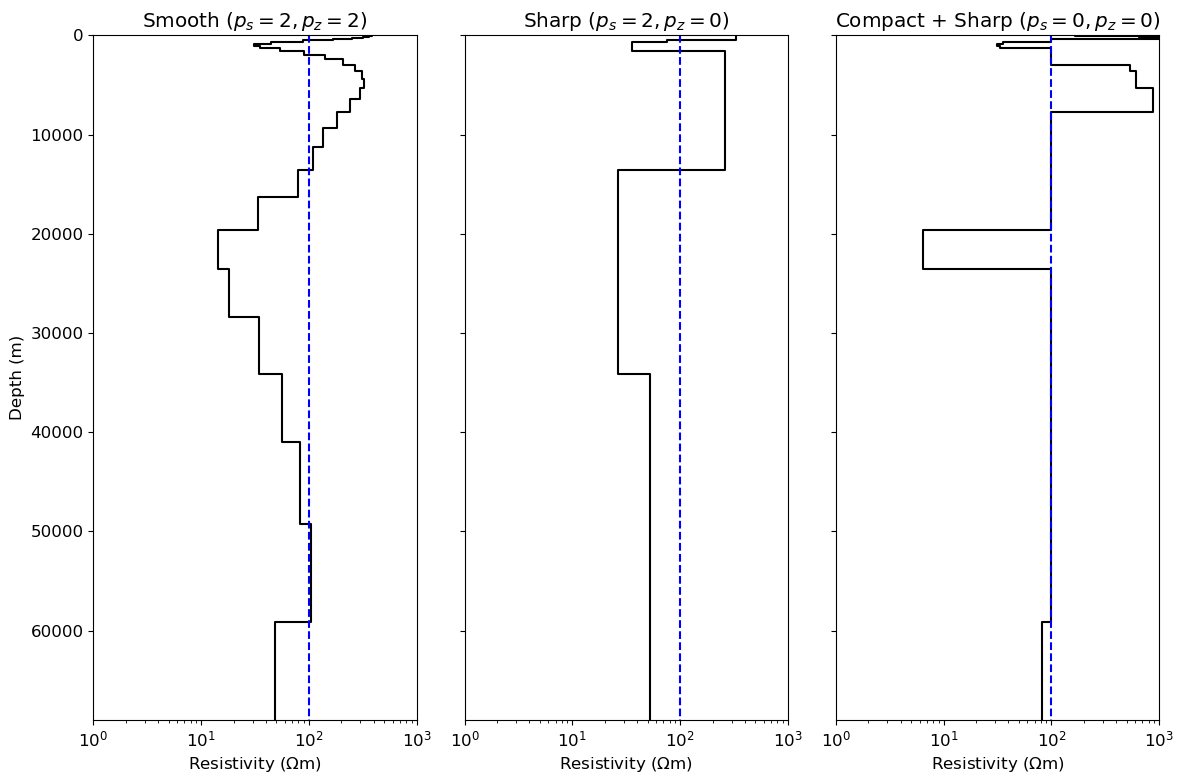

In [20]:
matplotlib.rcParams['font.size'] = 12
fig, axs = plt.subplots(1,3, figsize=(12, 8))
ax1, ax2, ax3 = axs
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(recovered_model)))[::-1],
    ax=ax1,
    color="k",**{'linestyle':'-'},
)
ax1.plot(rho_ref*np.ones([2,]), np.array([0, 70000]), color="b",**{'linestyle':'--'})

plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(recovered_model_ps_2_pz_0)))[::-1],
    ax=ax2,
    color="k",**{'linestyle':'-'},
)
ax2.plot(rho_ref*np.ones([2,]), np.array([0, 70000]), color="b",**{'linestyle':'--'})

plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(recovered_model_ps_0_pz_0)))[::-1],
    ax=ax3,
    color="k",**{'linestyle':'-'},
)
ax3.plot(rho_ref*np.ones([2,]), np.array([0, 70000]), color="b",**{'linestyle':'--'})

titles = [r"Smooth ($p_{s}=2, p_{z}=2$)", "Sharp ($p_{s}=2, p_{z}=0$)", "Compact + Sharp ($p_{s}=0, p_{z}=0$)"]
for ii, ax in enumerate(axs):
    ax.set_xlabel("Resistivity ($\Omega$m)")
    if ii>0:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.set_title(titles[ii])
    ax.set_xlim(1, 1000)
plt.tight_layout()

In [21]:
# Experimental plotting code for MTpy

In [22]:
# mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
# receivers_list = [
#     nsem.receivers.PointNaturalSource(component="real"),
#     nsem.receivers.PointNaturalSource(component="imag"),
# ]

# source_list = []
# for freq in frequencies:
#     source_list.append(nsem.sources.Planewave(receivers_list, freq))

# survey = nsem.survey.Survey(source_list)

# sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
# simulation = nsem.simulation_1d.Simulation1DRecursive(
#     survey=survey, 
#     sigmaMap=sigma_map,
#     thicknesses=layer_thicknesses_inv,
# )

In [23]:
# dobs = np.c_[tf.Z.res_xy, tf.Z.phase_xy].flatten()

In [24]:
# tf.Z.z[:,]

In [25]:
# dpred = simulation.dpred(m)

In [26]:
# plt.plot(dpred)

In [27]:
## Plot using `MTpy`?

In [28]:
# from mtpy import MT
# from mtpy.core import Z
# n_freq = len(frequencies)
# app_rho_matrix = np.zeros((n_freq, 2, 2), dtype=float)
# phase_matrix = np.zeros((n_freq, 2, 2), dtype=float)
# app_rho_matrix[:,0,1] = dpred.reshape((len(frequencies), 2))[:,0]
# app_rho_matrix[:,1,0] = dpred.reshape((len(frequencies), 2))[:,0]
# phase_matrix[:,0,1] = dpred.reshape((len(frequencies), 2))[:,1]
# phase_matrix[:,1,0] = dpred.reshape((len(frequencies), 2))[:,1]-180
# # or add apparent resistivity and phase
# z_object = Z()
# z_object.set_resistivity_phase(app_rho_matrix, phase_matrix, frequencies)

# tf_pred = MT()  
# tf_pred.Z = z_object

# tf_pred.survey_metadata.id = tf.survey_metadata.id
# tf_pred.station_metadata.id = 'ynp05s_pred'
# tf_pred.station_metadata.transfer_function.id = 'ynp05s_pred'
# # if this is 2D maybe we need a location
# tf_pred.station_metadata.location.latitude = tf.station_metadata.location.latitude 
# tf_pred.station_metadata.location.longitude = tf.station_metadata.location.longitude
# # mc.add_tf(tf_pred)

In [29]:
# mc.plot_mt_response(['YNP05S', 'ynp05s_pred'], plot_style="compare", plot_tipper='n')